In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib  as mpl

from mpl_toolkits.axes_grid1 import make_axes_locatable
from argparse import Namespace as NS
from os.path import join
import yaml
import torch
import torch.nn as nn
from syngan.models import OjaNet, OjaRule
from syngan.post_hoc_analysis import (make_new_data,
                                      generate_quiver, insets, rule_wrapper,
                                      plot_2Dheatmap)

from scipy.optimize import root
from matplotlib.cbook import get_sample_data


## Load fits and make data

In [3]:
# Load test data
path_to_data = join("..", "..", "data", "oja_net_small")
test_data = np.load(join(path_to_data, "extra_test_data.npz"))

with open(join(path_to_data, "config.yaml"), "r") as f:
    sconf = NS(**yaml.full_load(f))

X, Y, PCs, weights = test_data["presyn_act"], test_data["postsyn_act"],\
test_data["presyn_pcs"], test_data["weights"]

gt_net = OjaNet(OjaRule(sconf.n_presyn_neur, sconf.n_postsyn_neur),
                sconf.update_rate,
                sconf.n_presyn_neur,
                sconf.n_postsyn_neur,
                sconf.timesteps,
                noise_amplitude=0.)


In [4]:
# Load constrained rule and heatmap MLP
generators = {}

generators["gt"] = gt_net

prefix = ".."

# Load minimal test case
class WtNet(nn.Module):
    def __init__(self):
        super(WtNet, self).__init__()
        self.a = nn.Parameter(torch.randn(1), requires_grad=True)
        self.b = nn.Parameter(torch.randn(1), requires_grad=True)

    def forward(self, weight, presyn_activity, postsyn_activity):
        weight = weight.reshape(1, 3, 1)
        pre = presyn_activity.reshape(len(presyn_activity), 3, 1)
        post = postsyn_activity.reshape(len(presyn_activity), 1, 1)
        up_wt = (self.a * (post * pre) + self.b * ((post ** 2) * weight)).mean(0)
        return up_wt.unsqueeze(0)


chpt = torch.load(prefix + "/minimal_test_case/chpt_models.pt",
                  map_location=torch.device("cpu"))
wt_net = WtNet()
wt_net.a.data, wt_net.b.data = chpt["gen_state_dict"]["wt_net.a"].data.cpu(), chpt["gen_state_dict"]["wt_net.b"].data.cpu()
generators["minimal"] = OjaNet(wt_net)

# Load heatmap
class HeatMap(nn.Module):
    def __init__(self, heatmap):
        super(HeatMap, self).__init__()
        self.heatmap = heatmap

    def forward(self, weight, presyn_activity, postsyn_activity):
        W = weight.reshape(1, 3, 1).repeat(
            len(presyn_activity), 1, 1
        )
        X = presyn_activity.reshape(
            len(presyn_activity), 3, 1
        ).repeat(1, 1, 1)
        Y = postsyn_activity.reshape(
            len(postsyn_activity), 1, 1
        ).repeat(1, 3, 1)
        inputs = torch.cat([X, Y, W], -1).reshape(-1, 3)
        output = heatmap(inputs).reshape(-1, 3, 1).mean(0).unsqueeze(0)
        return output

heatmap = torch.load(prefix + "oja_net_small_addnal_exps/train_on_heatmaps/trained_mlp.pkl",
                     map_location=torch.device("cpu"))
generators["heatmap"] = OjaNet(HeatMap(heatmap),
                               sconf.update_rate,
                               sconf.n_presyn_neur,
                               sconf.n_postsyn_neur,
                               sconf.timesteps,
                               noise_amplitude=0.)


In [5]:
# Make new data
test_wts = {}
test_outputs = {}
test_score = {}

torch.manual_seed(786)
random_wts = 1e-1 * torch.abs(torch.randn(len(X), 3, 1))
for k, network in generators.items():
    wt, y, score = make_new_data(net="OjaNet",
                                 rule=network.update_rule,
                                 presyn_act=X,
                                 wt_init_seed=786,
                                 init_weights=random_wts,
                                 return_score=True,
                                 score_funcn="pc_norm",
                                 PCs=PCs)
    test_wts[k] = wt
    test_outputs[k] = y
    test_score[k] = score


## Set figure properties

In [22]:
# Set general properties for figure
labels = {"gt": "Oja's Rule",
          "minimal": "Constrained rule",
          "heatmap": "Local MLP \n trained on heatmap"}
colors = {"gt": "k",
          "minimal": "xkcd:lightblue",
          "heatmap": "xkcd:blue"
         }
linewidths = {"gt": 5,
              "minimal": 4,
              "heatmap": 4
             }

# Pick random set of datasets for plotting
panel_test_dataset=0
timebins = [9, 49, 199]
keys = ["minimal", "heatmap"]


def get_roots():
    x = 0.5
    roots = {"gt": {"y": [-.5, 0., 0.5],
                    "w": [-1, 0., 1],
                    "init_w": [-1, 1],
                    },
             "heatmap": {"y": [-.5, 0., 0.5],
                         "w": [],
                         "init_w": [-1, 0., 1],},
             "minimal": {"y": [-.5, 0., .5],
                         "init_w": [-1, 0., 1],
                         "w": []}
            }

    for key in [k for k in roots.keys() if k!="gt"]:
        for yy, rand in zip(roots[key]["y"], roots[key]["init_w"]):
            rootfinder = root(rule_wrapper(generators[key].update_rule), rand, args=(x, yy),
                              method='hybr')#, jac=jac_rule(loc_mlp))
            roots[key]["w"].append(rootfinder.x)
    return roots


## Make figure

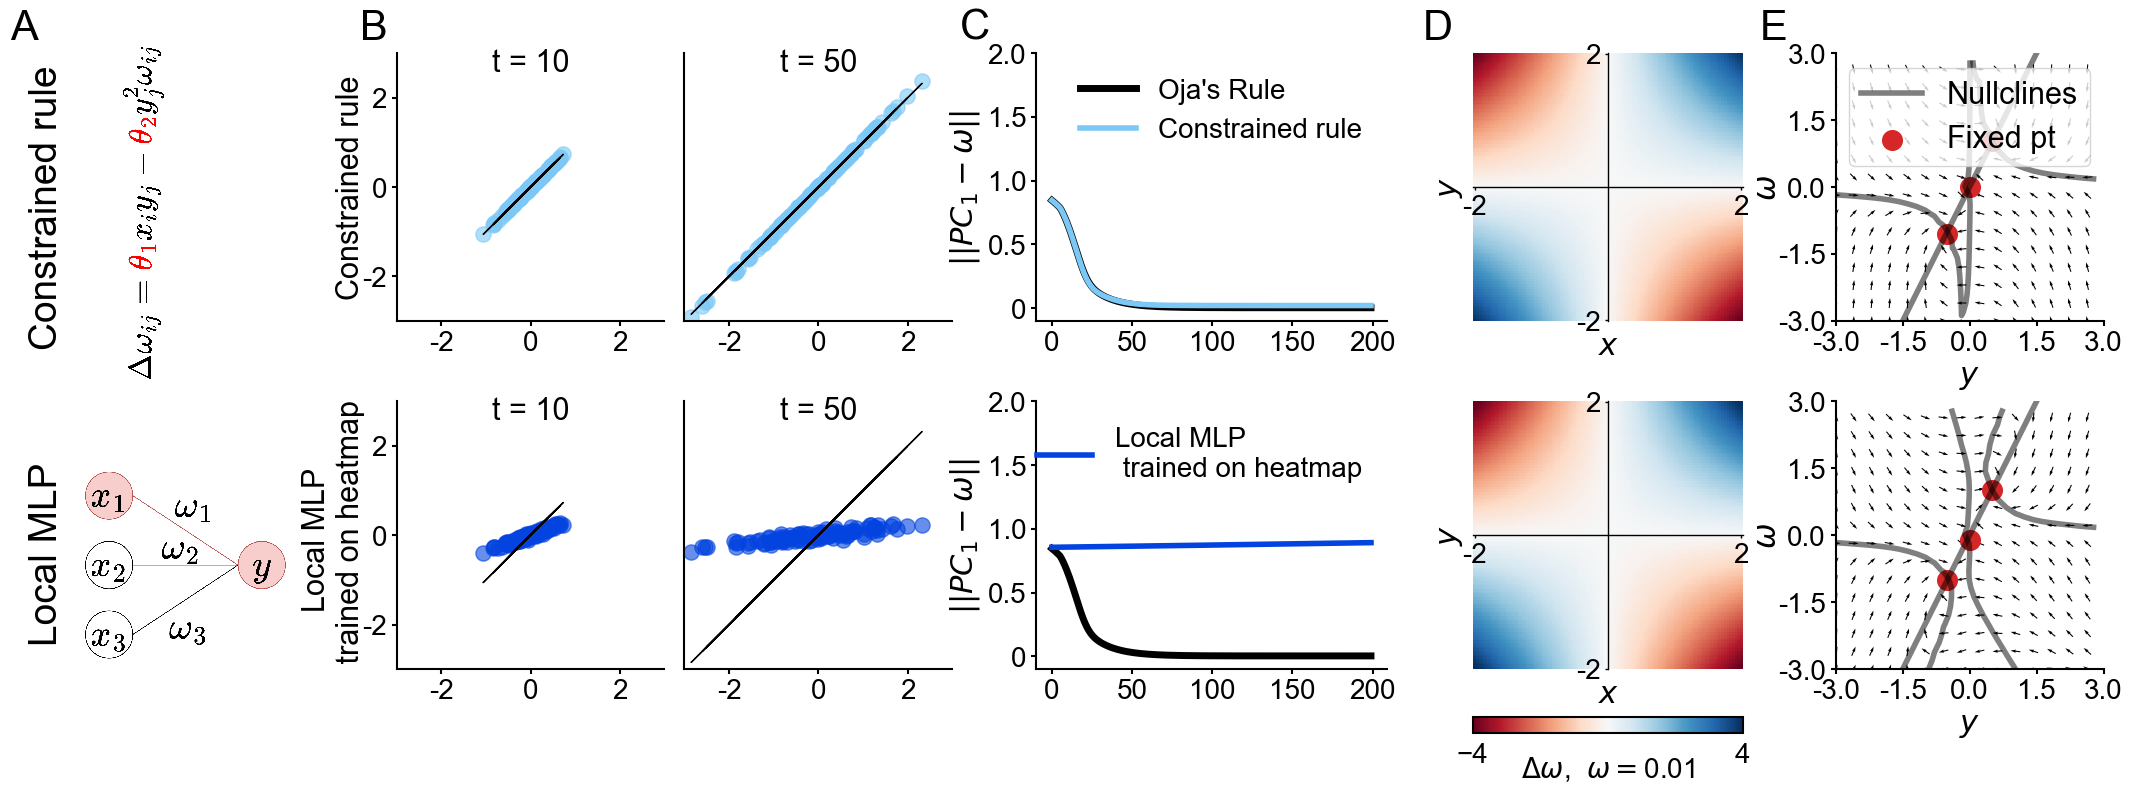

In [55]:
with mpl.rc_context(fname="./matplotlibrc"):
    fig = plt.figure(figsize=(25, 8))
    fig.patch.set_facecolor('white')
    fig.subplots_adjust(wspace=.25, hspace=.3)
    fig.tight_layout()

    gs = plt.GridSpec(2, 5, width_ratios=(1, 4, 2.5, 2, 2), height_ratios=(1., 1.))

    # Panel A
    cartoon_prefix = "../../cartoon_%s.png"
    for i, key in enumerate(keys):
        cartoon = "loc_mlp" if key=="heatmap" else "minimal"
        ax = plt.subplot(gs[i*5])
        if i == 0:
            im_ax = fig.add_axes([0.05, 0.47, .14, .42])
        if i == 1:
            im_ax = fig.add_axes([0.08, 0.09, .1, .3])
        im = plt.imread(get_sample_data(cartoon_prefix % cartoon))
        im_ax.imshow(im)
        im_ax.axis('off')
        ax.axis('off')


    # Panel B
    for i, (key, pn) in enumerate(zip(keys, [panel_test_dataset]*2)):
        ax = plt.subplot(gs[i*5 + 1])
        ax.axis('off')
        for j, (t, loc) in enumerate(zip(timebins[:-1], ["left", "right"])):
            div = make_axes_locatable(ax)
            ax = div.append_axes(loc, size="100%", pad=.2)
            insets(ax, t, key, pn, colors, labels, test_outputs, ylabel=labels[key],
                   fontsize=20, labelsize=22, titlesize=22)
            if i!=2:
                ax.set_xlabel("")

    # Panel C
    for i, (key, pn) in enumerate(zip(keys, [panel_test_dataset]*2,
                                            )
                                        ):
        ax = plt.subplot(gs[i*5 + 2])
        ax.set_xlabel("Time [a.u.]", fontsize=22)
        ax.set_ylabel(r"$||PC_1 - \omega||$", fontsize=22)
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_ylim(-.1, 2)
        ax.set_yticks([0, .5, 1., 1.5, 2.])
        ax.set_xticklabels(labels=[0, 50, 100, 150, 200], fontsize=20)
        ax.set_yticklabels(labels=[0, .5, 1., 1.5, 2.], fontsize=20)

        ax.plot(test_score["gt"][pn].T,
                 color=colors["gt"],
                 lw=linewidths["gt"],
                 alpha=1.,
                 label=labels["gt"] if i==0 else "")
        ax.plot(test_score[key][pn].T,
                 color=colors[key],
                 lw=linewidths[key],
                 alpha=1.,
                 label=labels[key])
        if i!=2:
            ax.set_xlabel("")
        ax.legend(fontsize=20)

    # Panel D
    cax = fig.add_axes((.645, .03, .108, .02))

    for i, (key, colax) in enumerate(zip(keys, [None, cax])):
        ax = plt.subplot(gs[i*5 + 3])
        plot_2Dheatmap(rule_wrapper(generators[key].update_rule
                                    if key != "heatmap" else generators[key].update_rule.heatmap),
                       ax,
                       0.01,
                       cax=colax,
                       x_range = [-2,2],
                       y_range = [-2,2],
                       n_points = [100,100],
                       fontsize=20,
                       labelsize=22,
                       labelpad=80)


    # Panel E
    x = 0.5
    for i, (key, lim) in enumerate(zip(keys, [[-3, 3], [-3, 3]])):
        ax = plt.subplot(gs[i*5 + 4])
        roots = get_roots()
        w_range = np.linspace(lim[0], lim[1], 150)
        y_range = np.linspace(lim[0], lim[1], 150)

        Y, W, DY, DW = generate_quiver(rule_wrapper(generators[key].update_rule
                                                    if key != "heatmap" else generators[key].update_rule.heatmap),
                                       w_range=w_range, y_range=y_range)
        ax.quiver(Y[::2, ::2], W[::2, ::2], DY[::2, ::2], DW[::2, ::2], pivot='mid')
        ax.set_xlim(lim[0], lim[1])
        ax.set_ylim(lim[0], lim[1])
        ax.set_aspect(1)
        ax.set_xticks(np.linspace(lim[0], lim[1], 5))
        ax.set_xticklabels(np.linspace(lim[0], lim[1], 5), fontsize=20)
        ax.set_yticks(np.linspace(lim[0], lim[1], 5))
        ax.set_yticklabels(np.linspace(lim[0], lim[1], 5), fontsize=20)
        ax.set_xlabel(r"$y$", fontsize=22)
        ax.set_ylabel(r"$\omega$", fontsize=22, labelpad=-2.5)


        y_fp, w_fp = roots[key]["y"], roots[key]["w"]
        ax.contour(Y, W, DW, [0], colors="k", alpha=.5, linewidths=[4])
        ax.plot(w_range * x, w_range, lw=4, color="k", alpha=.5, label="Nullclines")
        ax.scatter(y_fp, w_fp, s=200, color="tab:red", label="Fixed pt")

        if i==0:
            ax.legend(frameon=True, fontsize=22, loc="upper center")

    fig.text(0.06, .897, "A", fontsize=30)
    fig.text(0.2, .897, "B", fontsize=30)
    fig.text(0.44, .897, "C", fontsize=30)
    fig.text(0.625, .897, "D", fontsize=30)
    fig.text(0.76, .897, "E", fontsize=30)

    fig.text(0.075, .52, "Constrained rule", fontsize=28, ha='center', rotation='vertical')
    fig.text(0.075, .15, "Local MLP", fontsize=28, ha='center', rotation='vertical')


    fig.savefig("supp_fig_1.jpg")
